### Notebook for the __extra__ hands on session 1 (using python wrapper)

So far, we have performed ALM calculations using the C++ binary.

We are also developing a python wrapper to ALM, which can be downloaded from https://github.com/ttadano/ALM.

The detailed instruction for installation is available at https://alm.readthedocs.io/en/develop/.

Here, we demonstrate how to use ALM python wrapper.


In [4]:
# import libraries
import numpy as np
from alm import ALM
from pymatgen.core import Structure

In [102]:
# define methods for LASSO
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import lasso_path
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import math

def run_lasso_cv(X, y, force, nat, ndata, nfold=4):

    force_ravel = force.reshape(-1)

    print("force shape: ", np.shape(force_ravel))
    print("Amat shape : ", np.shape(X))

    groups = []
    for i in range(ndata):
        groups.extend([i] * 3 * nat)

    eps = 1.0e-7
    gkf = GroupKFold(n_splits=nfold)
    n_alphas = 50

    rms_train = np.zeros((n_alphas, nfold))
    rms_test = np.zeros((n_alphas, nfold))

    counter = 0
    alphas = np.logspace(-1, -6, num=n_alphas)

    standardize = True
    sc = StandardScaler()

    for train, test in gkf.split(X, y, groups=groups):

        force_train = force_ravel[train]
        force_test = force_ravel[test]
        fnorm_train = np.dot(force_train, force_train)
        fnorm_test = np.dot(force_test, force_test)

        # Set displacement and force data
        X_train = X[train, :]
        X_test = X[test, :]
        y_train = y[train]
        y_test = y[test]

        if standardize:
            scaler = sc.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)


        alphas_lasso, coefs_lasso, _ = lasso_path(X_train, y_train, eps=eps, 
                                                  alphas = alphas,
                                                  verbose = True,
                                                  max_iter = 100000)

        y_model_train = np.dot(X_train, coefs_lasso)
        y_model_test = np.dot(X_test, coefs_lasso)


        for ialpha in range(n_alphas):
            y_diff_train = y_model_train[:,ialpha] - y_train
            y_diff_test = y_model_test[:,ialpha] - y_test

            residual_train = np.dot(y_diff_train, y_diff_train)
            residual_test = np.dot(y_diff_test, y_diff_test)

            rms_train[ialpha, counter] = math.sqrt(residual_train/fnorm_train)
            rms_test[ialpha, counter] = math.sqrt(residual_test/fnorm_test)


        counter += 1

    rmse_mean = np.mean(rms_train, axis=1)
    rmse_std = np.std(rms_train, axis=1, ddof=1)
    cv_mean = np.mean(rms_test, axis=1)
    cv_std = np.std(rms_test, axis=1, ddof=1)
    
    return alphas, rmse_mean, rmse_std, cv_mean, cv_std


def run_lasso(X, y, alpha_opt, standardize=True):

    eps=1.0e-6
    clf = Lasso(alpha=alpha_opt, fit_intercept=False, tol=eps, max_iter=10000)

    if standardize:
        sc = StandardScaler()
        scaler = sc.fit(X)
        X = scaler.transform(X)
        clf.fit(X, y)
        fc = np.true_divide(clf.coef_, scaler.scale_)

    else:
        clf.fit(X, y)
        fc = clf.coef_

    return fc

In [16]:
# load primitive cell structure
structure = Structure.from_file('work/primitive.POSCAR.vasp')

# Create supercell
scaling_matrix = [[ 5, 0, 0],
                  [ 0, 5, 0],
                  [ 0, 0, 1]]

Structure.make_supercell(structure, scaling_matrix)

In [17]:
structure

Structure Summary
Lattice
    abc : 12.2325 12.232500000000003 15.0
 angles : 90.0 90.0 119.99999999999999
 volume : 1943.8034097571458
      A : 12.2325 0.0 0.0
      B : -6.11625 10.59365575179315 0.0
      C : 0.0 0.0 15.0
PeriodicSite: C (1.2233, 0.7062, 0.0000) [0.1333, 0.0667, 0.0000]
PeriodicSite: C (0.0000, 2.8250, 0.0000) [0.1333, 0.2667, 0.0000]
PeriodicSite: C (-1.2232, 4.9437, 0.0000) [0.1333, 0.4667, 0.0000]
PeriodicSite: C (-2.4465, 7.0624, 0.0000) [0.1333, 0.6667, 0.0000]
PeriodicSite: C (-3.6697, 9.1812, 0.0000) [0.1333, 0.8667, 0.0000]
PeriodicSite: C (3.6698, 0.7062, 0.0000) [0.3333, 0.0667, 0.0000]
PeriodicSite: C (2.4465, 2.8250, 0.0000) [0.3333, 0.2667, 0.0000]
PeriodicSite: C (1.2233, 4.9437, 0.0000) [0.3333, 0.4667, 0.0000]
PeriodicSite: C (0.0000, 7.0624, 0.0000) [0.3333, 0.6667, 0.0000]
PeriodicSite: C (-1.2232, 9.1812, 0.0000) [0.3333, 0.8667, 0.0000]
PeriodicSite: C (6.1163, 0.7062, 0.0000) [0.5333, 0.0667, 0.0000]
PeriodicSite: C (4.8930, 2.8250, 0.0000) [0.

In [45]:
# structure information 
lavec = structure.lattice.matrix * 1.88972612545782819321
positions = structure.frac_coords
kinds = structure.atomic_numbers
nat = structure.num_sites

In [79]:
# Load training dataset

dfset_harmonic = np.loadtxt('work/DFSET_harmonic')
dfset_random = np.loadtxt('work/DFSET_random')

disp_harmonic = dfset_harmonic[:, :3].reshape((-1, nat, 3))
force_harmonic = dfset_harmonic[:, 3:].reshape((-1, nat, 3))

disp_random = dfset_random[:, :3].reshape((-1, nat, 3))
force_random = dfset_random[:, 3:].reshape((-1, nat, 3))

In [88]:
# Fit harmonic force constants and save information as fc2_values and elem2_indices

maxorder = 1

cutoff = [-1] # None corresponds to -1

with ALM(lavec, positions, kinds) as alm:
    alm.set_verbosity(0) # set to 0 to suppress outputs
    alm.define(maxorder, cutoff, symmetrization_basis="Cartesian")
    alm.set_constraint(translation=True)
    alm.displacements = disp_harmonic
    alm.forces = force_harmonic
    info = alm.optimize()
    fc2_values, elem2_indices = alm.get_fc(1)
    alm.save_fc('graphene_harmonic_python.xml', format='alamode')


In [106]:
# Create sensing matrix A and vector b for performing LASSO estimate

# Anharmonic model up to the 4th-order
maxorder = 3
cutoff = [-1, 8.1, 8.1] # None corresponds to -1
nbody = [2, 3, 3]
with ALM(lavec, positions, kinds) as alm:
    alm.set_verbosity(0) # set to 0 to suppress outputs
    alm.define(maxorder, cutoff, nbody, symmetrization_basis="Cartesian")
    alm.set_constraint(translation=True)
    alm.displacements = disp_random
    alm.forces = force_random

    # Fix harmonic force constants upon optimization
    alm.freeze_fc(fc2_values, elem2_indices) # works same as FC2XML
    
    # Get sensing matrix 
    X, y = alm.get_matrix_elements()

    # Run CV
    alphas, rmse_mean, rmse_std, cv_mean, cv_std \
    = run_lasso_cv(X, y, force_random, nat=50, ndata=20, nfold=4)
    
    # optimize with optimal alpha
    fc = run_lasso(X, y, alpha_opt=alphas[np.argmin(cv_mean)])
    
    # Set force constant values to the alm object
    alm.set_fc(fc)
    
    # Save force constants in XML files
    alm.save_fc('graphene_anharmonic_python.xml', format='alamode')


force shape:  (3000,)
Amat shape :  (3000, 529)


........................................................................................................................................................................................................

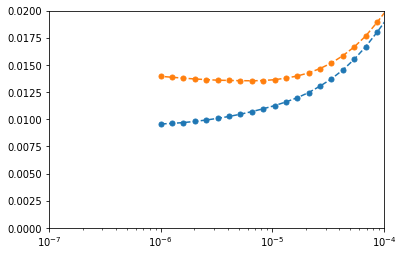

In [98]:
%matplotlib inline

import matplotlib.pyplot as plt

ax = plt.subplot(111)
ax.plot(alphas, rmse_mean, linestyle='--', marker='o', ms=5)
ax.plot(alphas, cv_mean, linestyle='--', marker='o', ms=5)
ax.set_ylim(0, 0.02)
ax.set_xlim(1.0e-7, 1.0e-4)
ax.set_xscale('log')
plt.show()